In [2]:
# Lecture des données
rm(list = ls())
library(Matrix)
library(RCurl)
u.data <- read.csv('u.data.csv', sep='|', header=T)
head(u.data)
m <- sparseMatrix(u.data[,1],u.data[,2],x=u.data[,3])
rownames(m) <- paste('u', 1:nrow(m), sep='')
colnames(m) <- paste('i', 1:ncol(m), sep='')
m <- as.matrix(m)
## m est u.data
m.na <- m
m.na[m==0] <- NA
m.na2 <- m.na

user.id,item.id,rating,timestamp
196,242,3,881250949
186,302,3,891717742
22,377,1,878887116
244,51,2,880606923
166,346,1,886397596
298,474,4,884182806


In [3]:
# Question 1
## Votes au hasard
m.hasard <- m.na
m.hasard[m>0] <- sample(m.hasard[m>0], sum(m>0))
mae <- function(m1, m2) mean(abs(m1 - m2), na.rm=T)
mse <- function(m1, m2) mean((m1 - m2)*(m1 - m2), na.rm=T)
### La première approche test est celle du vote au hasard.
mae(m.hasard, m.na)

## Deuxième et troisième approche : moyenne de l'utilisateur et moyenne de l'item
u.mean <- matrix(rowMeans(m.na, na.rm=T), nrow(m), ncol(m))
item.mean <- matrix(colMeans(m.na, na.rm=T), nrow(m), ncol(m), byrow=T)
mae(m.na, u.mean)
mae(m.na, item.mean)

## Mélange : moyenne de la note moyenne de l'item et celle de l'utilisateur 
m.expect <- ((u.mean + item.mean)/2)
corner <- function(m, ...) head(t(tail(t(m), ...)), ...)
corner(m.expect)
mae(m.expect, m.na)

### On note que l'utilisation de la moyenne utilisateur seule fournit un bon score en terme d'erreur.
### Cependant, utiliser la moyenne utilisateur comme baseline n'a pas de sens car on donne à chaque item la même note :
### comment alors recommander un item à  un utilisateur ?
### Utiliser la moyenne des items est beaucoup plus pertinent, cela revient à recommander les items les plus populaires.
### m.expect permet d'associer les deux aspects; on obtient d'ailleurs un meilleur score d'erreur.
### On notera que les trois approches donnent une MAE bien moindre que l'approche aléatoire.

[1] 1.23214

[1] 0.8262264

[1] 0.7989582

"[1677,]","[1678,]","[1679,]","[1680,]","[1681,]","[1682,]"
3.305147,2.305147,3.305147,2.805147,3.305147,3.305147
3.354839,2.354839,3.354839,2.854839,3.354839,3.354839
2.898148,1.898148,2.898148,2.398148,2.898148,2.898148
3.666667,2.666667,3.666667,3.166667,3.666667,3.666667
2.937143,1.937143,2.937143,2.437143,2.937143,2.937143
3.317536,2.317536,3.317536,2.817536,3.317536,3.317536


[1] 0.7825831

In [4]:
# Question 2 + question 3
## Normalisation, décomposition SVD et prédiction (10 dimensions)

## Normalisation telle que réalisée dans la partie "expérience pratique" (qui donne le graphe qu'on doit reproduire)
fillingPratique <- function(m.na){
  votes.utilisateurs.moyen <- rowMeans(m.na, na.rm=T)
  `%-=%` = function(e1,e2) eval.parent(substitute(e1 <- e1 - e2))
  votes.items.moyen <- colMeans(m.na, na.rm=T)
  indx <- is.na(t(m.na))
  m.filled <- t(m.na)
  m.filled[indx] <- votes.items.moyen[col(m.filled)][indx]
  m.filled <- t(m.filled)
  m.filled[,1:ncol(m)] %-=% votes.utilisateurs.moyen
  dim(m.filled)
  return(m.filled)
}

## Remplacement des NA par les votes moyens sur les items correspondants
indx <- is.na(t(m.na))
m.filled <- t(m.na)
m.filled[indx] <- votes.items.moyen[col(m.filled)][indx]
m.filled <- t(m.filled)
## Normalisation en soustrayant les votes moyens des utilisateurs correspondants
m.filled[,1:ncol(m)] %-=% votes.utilisateurs.moyen
# SVD
m.svd <- svd(m.filled)

## Normalisation telle que réalisée dans l'article dans la partie théorique (partie 3)
fillingTheorique <- function(m.na){
  m.filled.th <- m.na
  m.filled.th[is.na(m.filled.th)] <- 0
  m.filled.th <- m.filled.th - item.mean
  return(m.filled.th)
}

In [5]:
## Fonction réalisant la prédiction des votes après SVD avec un certain nombres de dimensions.
predsvd <- function(nbdim, d, u, v, votes.items.moyen){
  d.reduced <- d[1:nbdim]
  d.squared <- diag(sqrt(d.reduced))
  diag(d.squared)
  usk <- u[,1:nbdim] %*% d.squared
  vsk <- d.squared %*% t(v[,1:nbdim])
  
  ### Gagne du temps pour l'estimation du vote
  m.reconstruit <- usk %*% vsk
  
  prediction <- function(user, item, votes.items.moyen) {
    if (is.na(m.na[user,item]))
      res <- NA
    else {
      res <- votes.items.moyen[user,item] +  m.reconstruit[user,item]
    }
    return(res)
  }
  test <- sapply(1:943, function(i){#if (i%% 50 == 0) {print(i)};
    
    sapply(1:1682, function(j) prediction(i,j, votes.items.moyen))})
  
  return(t(test))
}

## Wrapper qui (1) fait la décomposition SVD et (2) fait les calculs de prédiction :
predVotes <- function(mat,nbdim,votes.items.moyen){
  svd <- svd(mat)
  return(predsvd(nbdim,svd$d,svd$u,svd$v,votes.items.moyen))
}

In [6]:
## Utilitaire : découpage en ensemble d'entraînement et ensemble de validation.
### Renvoie le training set et la matrice booléenne des indices changés 
### (pour pouvoir après calculer la MAE seulement sur les valeurs changées)
split <- function(m, ratio){
  i.observed <- which(m > 0)
  i.hasard <- sample(i.observed, length(i.observed))
  length(i.hasard)
  fold.size <- round(length(i.hasard) * ratio)
  i.false <- rep(FALSE, length(m))
  ## Index booléen pour les cellules de test et d'entraînement
  i.test.b <- i.false ## Les cellules indexées du replis correspondant sont fixées à TRUE pour le test...
  i.test.b[ i.hasard[1:  fold.size]] <- TRUE ## ...et à FALSE pour l'entraînement
  i.train.b <-  !i.test.b
  m.na.train <- m
  m.na.train[i.test.b] <- NA  # on enlève les données de test pour l'entraînement
  return(list(m.na.train, i.test.b))
}

In [ ]:
## Découpage et décomposition SVD
dd <- split(m.na,0.1)
testIndices <- dd[[2]]

### Deux normalisations possibles
#### ne fonctionne pas dans cet ordre
m.filled <- fillingPratique(dd[[1]])
#### (sinon, il reste des valeurs manquantes et la décomposition SVD est impossible)
m.na.pr <- fillingPratique(m.na)
dd.pr <- split(m.na.pr, 0.1)
m.filled <- dd.pr[[1]]
testIndices.pr <- dd.pr[[2]]
#### fonctionne en faisant la normalisation avant ou après la séparation
m.filled.th <- fillingTheorique(dd[[1]])

In [20]:
m.svd <- svd(m.filled)
d <- m.svd$d
u <- m.svd$u
v <- m.svd$v

m.svd2 <- svd(m.filled.th)
d2 <- m.svd2$d
u2 <- m.svd2$u
v2 <- m.svd2$v

### Prédiction des votes
test <- predVotes(m.filled.th, 10, item.mean)
test.pr <- predVotes(m.filled, 10, item.mean)

ERROR: Error in svd(m.filled): infinite or missing values in 'x'


In [16]:
m.na.pr

,i1,i2,i3,i4,i5,i6,i7,i8,i9,i10,⋯,i1673,i1674,i1675,i1676,i1677,i1678,i1679,i1680,i1681,i1682
u1,5,3,4,3,3,5,4,1,5,3,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
u2,NA,NA,NA,NA,NA,NA,NA,NA,NA,2,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
u3,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
u4,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
u5,NA,3,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
u6,4,NA,NA,NA,NA,NA,2,4,4,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
u7,NA,NA,NA,5,NA,NA,5,5,5,4,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
u8,NA,NA,NA,NA,NA,NA,3,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
u9,NA,NA,NA,NA,NA,5,4,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
u10,4,NA,NA,4,NA,NA,4,NA,4,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


,i1,i2,i3,i4,i5,i6,i7,i8,i9,i10,⋯,i1673,i1674,i1675,i1676,i1677,i1678,i1679,i1680,i1681,i1682
u1,5,3,4,3,3,5,4,1,5,3,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
u2,4,NA,NA,NA,NA,NA,NA,NA,NA,2,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
u3,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
u4,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
u5,4,3,NA,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
u6,4,NA,NA,NA,NA,NA,2,4,4,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
u7,NA,NA,NA,5,NA,NA,5,5,5,4,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
u8,NA,NA,NA,NA,NA,NA,3,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
u9,NA,NA,NA,NA,NA,5,4,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
u10,4,NA,NA,4,NA,NA,4,NA,4,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [ ]:
# Question 4
## Erreur absolue moyenne
mae(m.na[testIndices] , test[testIndices])
mae(m.na[testIndices] , test.pr[testIndices.pr])

## Erreur quadratique moyenne
mse(m.na[testIndices] , test[testIndices])
mse(m.na[testIndices] , test.pr[testIndices.pr])

In [5]:
#############################################################################
## Ce code représente un exemple de prédictions avec des valeurs au
## hasard et les valeurs attendues
#############################################################################

library(Matrix)
library(RCurl)
u.data <- read.csv('u.data.csv', sep='|', header=T)
head(u.data)
m <- sparseMatrix(u.data[,1],u.data[,2],x=u.data[,3])
rownames(m) <- paste('u', 1:nrow(m), sep='')
colnames(m) <- paste('i', 1:ncol(m), sep='')
m <- as.matrix(m)
## m est u.data
m.na <- m
m.na[m==0] <- NA
############################################################################
### Votes au hasard
m.hasard <- m.na
m.hasard[m>0] <- sample(m.hasard[m>0], sum(m>0))
mae <- function(m1, m2) mean(abs(m1 - m2), na.rm=T)
mae(m.hasard, m.na)
0

Loading required package: bitops


user.id,item.id,rating,timestamp
196,242,3,881250949
186,302,3,891717742
22,377,1,878887116
244,51,2,880606923
166,346,1,886397596
298,474,4,884182806


[1] 1.23382

[1] 0

In [10]:
# Question 2
# Normalisation
## Calcul des votes moyens
votes.utilisateurs.moyen <- rowMeans(m.na, na.rm=T)
votes.items.moyen <- colMeans(m.na, na.rm=T)
## Utilitaires
`%-=%` = function(e1,e2) eval.parent(substitute(e1 <- e1 - e2))
`%+=%` = function(e1,e2) eval.parent(substitute(e1 <- e1 + e2))
## Remplacement des NA par les votes moyens sur les items correspondants
indx <- is.na(t(m.na))
m.filled <- t(m.na)
m.filled[indx] <- votes.items.moyen[col(m.filled)][indx]
m.filled <- t(m.filled)
## Normalisation en soustrayant les votes moyens des utilisateurs correspondants
m.filled[,1:ncol(m)] %-=% votes.utilisateurs.moyen
# SVD
m.svd <- svd(m.filled)

In [11]:
m.svd

-0.0090772048,-0.0479328618,0.053155162,-0.043990261,0.0586845020,-1.355183e-02,0.0086248914,-0.026528565,0.0451619008,-0.0697301488,⋯,5.256302e-04,-2.996929e-03,-0.0011494794,-0.0002004632,-0.0024368002,1.847131e-03,8.390819e-04,3.825094e-03,-0.0009611534,-3.078103e-04
0.0201521610,0.0003210428,0.018116607,-0.023683360,0.0167378273,5.770178e-04,0.0339264093,0.014524788,0.0248497985,-0.0142828332,⋯,3.578550e-03,3.225834e-03,0.0196315219,0.0029826269,0.0246061043,1.622541e-02,-2.954271e-02,9.792559e-03,-0.0298329944,1.650784e-02
-0.0094716446,-0.0102608816,-0.001030076,0.003437766,0.0017495459,-2.174585e-04,0.0024173813,-0.009498727,0.0014685593,0.0068813126,⋯,-2.087337e-02,-1.353660e-02,-0.0019898020,-0.0070559982,-0.0380417257,-1.002654e-03,2.643368e-04,-1.630262e-02,0.0116143368,1.387024e-03
0.0318514917,0.0174664850,0.010771045,-0.003176894,0.0105172343,-1.150606e-02,0.0011353792,-0.001656401,0.0060030014,0.0134787158,⋯,-2.223367e-02,-1.053711e-02,0.0428660344,0.0299183162,-0.0050915304,1.784596e-02,-2.080919e-02,8.445235e-03,-0.0591589005,-1.936350e-02
-0.0156522111,-0.0358315970,0.027861250,-0.045982240,0.0430577161,-2.441518e-02,-0.0162139792,0.007193519,0.0314637202,-0.0540773411,⋯,1.697076e-03,-1.292060e-03,0.0016545991,0.0009714195,-0.0021282632,-1.244660e-03,-1.190254e-03,6.132389e-05,-0.0002326441,2.154531e-04
0.0021336907,-0.0347995705,0.063183855,0.036676822,-0.0361939130,1.734870e-03,-0.0249540753,0.018229852,-0.0152544188,0.0220234154,⋯,4.351589e-05,1.759035e-03,0.0027031616,-0.0041816718,-0.0021316548,4.733173e-03,-7.878554e-05,1.752631e-03,0.0048753896,-1.939597e-04
0.0056350560,-0.0774861901,0.019977734,0.003185421,-0.0343082546,-2.034031e-02,-0.0299847213,-0.008135718,-0.0706287660,-0.0183307522,⋯,1.888940e-04,2.660527e-03,-0.0007488932,-0.0011978679,0.0008081011,1.326445e-03,-2.796435e-04,-1.261808e-04,0.0015943886,7.268860e-04
-0.0078176301,-0.0231010283,0.004222417,-0.003908090,0.0189269822,-1.373383e-02,0.0046158091,-0.001936268,-0.0002189633,-0.0081597072,⋯,-2.922840e-03,-1.161456e-02,0.0013289140,0.0218465538,0.0005768803,5.445535e-03,1.219436e-03,-7.851207e-03,-0.0003481110,-2.606827e-03
0.0153282100,0.0050276524,0.005521174,0.004463047,0.0009484796,-5.605089e-03,-0.0023714333,-0.008137387,0.0056337115,0.0012215096,⋯,-1.313251e-02,1.433899e-02,-0.0125167275,0.0154165790,0.0068552331,-1.485340e-02,4.122939e-03,-1.801502e-03,0.0093221306,2.220719e-03
0.0140216977,-0.0324312151,0.024432273,0.007388676,-0.0236268443,8.025056e-03,-0.0172796504,0.017365194,-0.0431700902,0.0108072763,⋯,-1.247286e-02,-2.129692e-03,-0.0001615274,-0.0018857375,-0.0009455801,1.319368e-03,-5.355190e-03,-1.463222e-04,0.0018460097,5.085278e-03
-0.0141498040,-0.0062812316,0.024186949,-0.027629910,0.0051759843,-2.609445e-02,0.0374523953,-0.005620307,-0.0060081083,0.0050953604,⋯,-2.578505e-03,2.498681e-03,0.0024846223,-0.0025095669,-0.0008516476,-1.226769e-03,3.028065e-03,3.010737e-03,-0.0011917964,6.506768e-04


In [48]:
# Question 5
# Matrices U, S et V
U <- m.svd$u
S <- diag(m.svd$d)
V <- m.svd$v
# Matrices Sk
compute.Sk <- function(k){
    return(diag(m.svd$d[1:k]))
}
list.Sk <- list()
aux <- c(2,5:21,25,50,100)
list.Sk <- lapply(aux, compute.Sk)
length(list.Sk)

[1] 21

In [49]:
# Racine carrée de chaque Sk
# Note : diag n'est pas une opération très efficace.
list.Sk.roots <- lapply(list.Sk, function(x) diag(sqrt(diag(x))))

In [101]:
# Uk*Sk^1/2 et Sk^1/2*Vk
list.Uk <- lapply(aux, function(k) U[,1:k])
list.Vk <- lapply(aux, function(k) V[,1:k])
list.UkSk <- mapply(function(M,N) M%*%N, list.Uk, list.Sk.roots)
list.SkVk <- mapply(function(M,N) M%*%t(N), list.Sk.roots, list.Vk)
# UkSkVk'
list.UkSkVk <- list()
list.UkSkVk <- mapply(function(M,N) M%*%N, list.UkSk, list.SkVk, SIMPLIFY=F)
# Dénormalisation
tmp <- 1:21
P <- lapply(tmp, function(k) {list.UkSkVk[[k]][,1:1682] %+=% votes.utilisateurs.moyen; list.UkSkVk[[k]]})

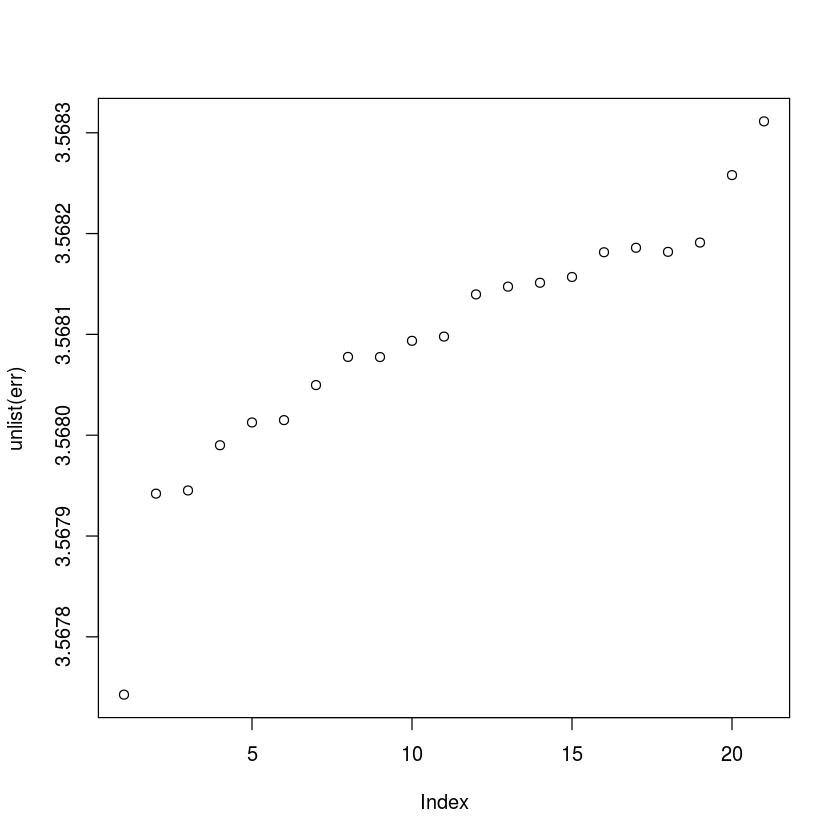

In [118]:
# Prediction (MAE)
votes.attendus <- outer(votes.utilisateurs.moyen, votes.items.moyen, FUN='+')/2# pas sûre du tout qu'on doive comparer à ça
err <- lapply(tmp, function(k) mae(votes.attendus, P[[k]]))
plot(unlist(err))
# d'autant que comme ça on a une erreur strictement croissante selon le nombre de dimensions, pareil avec m.hasard
# ce qui est normal : on compare à la moyenne ; moins on a de dimensions, moins on a de détails, moins on a d'écart à la moyenne
# mais ça ne nous apporte pas l'information nécessaire pour trouver la dimension idéale

[1] 6

m.na.train
    1     2     3     4     5 
 5062  9470 22479 28405 17695 

[1] NaN

[1] 21

[1] 3.589529

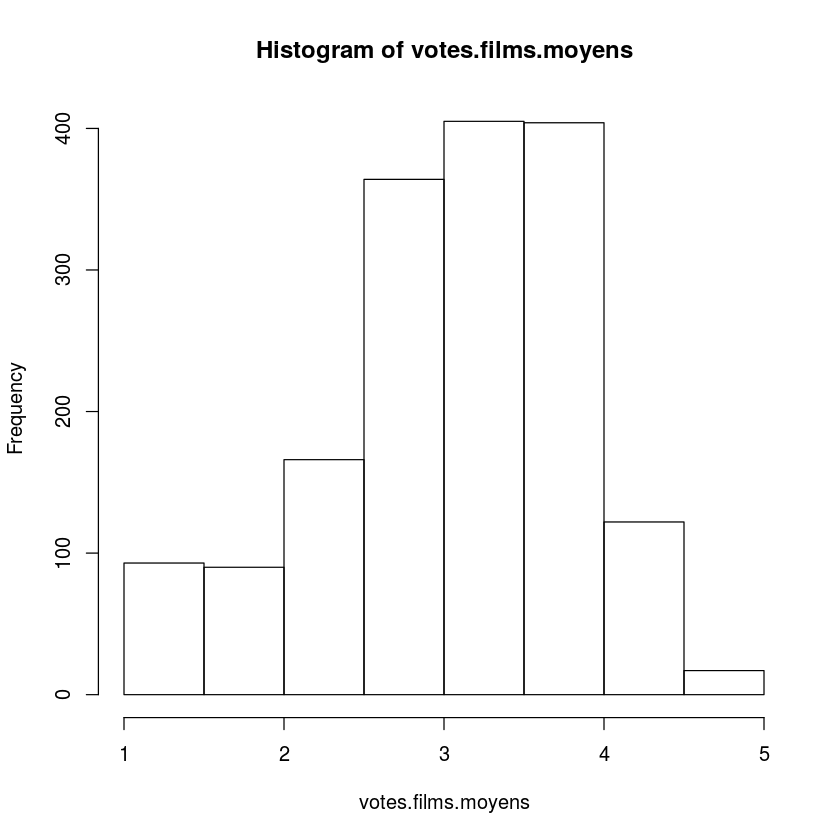

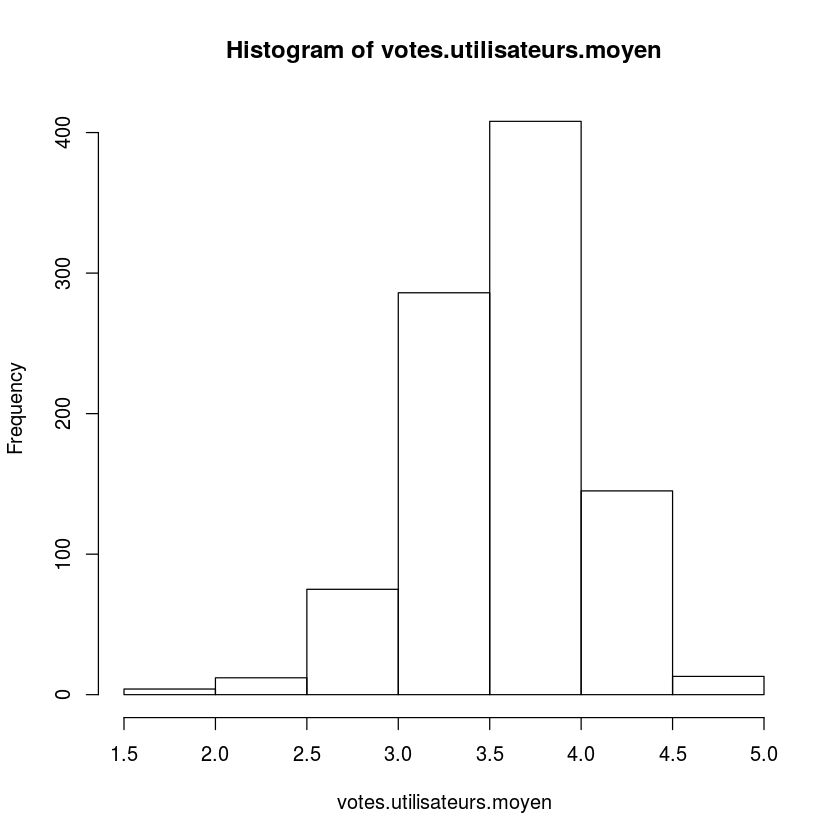

[1] 0.477316

[1] 0.477316

[1] 0.567766

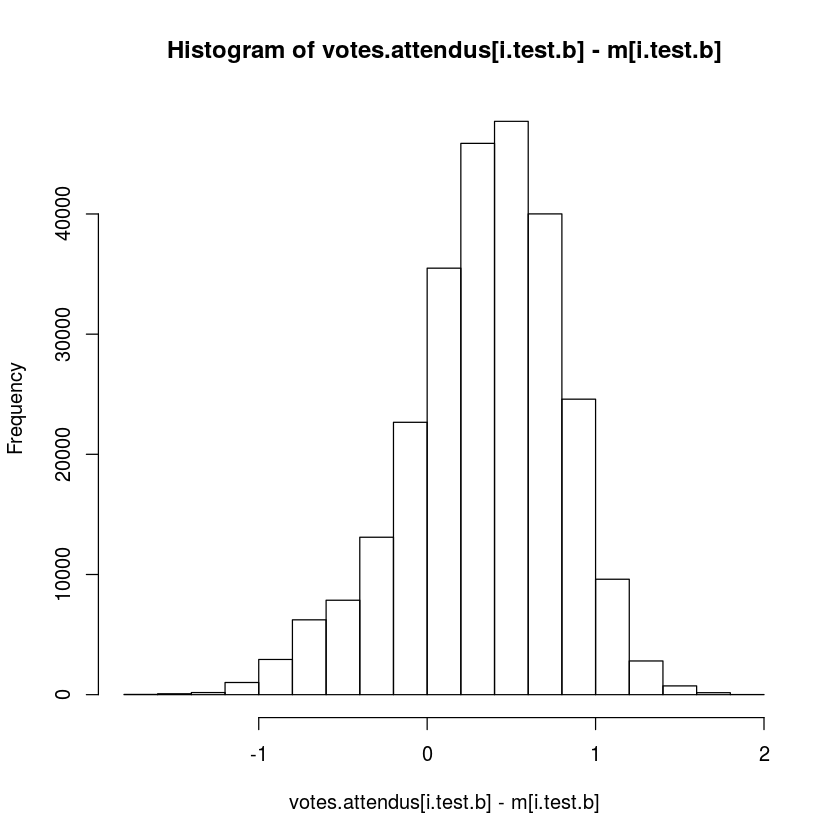

In [115]:
#############################################################################
## Avec validation croisée basée sur 10 replis (10 folds).## Le code ne fait qu'un replis.
## Le principe consiste premièrement à créer un vecteur de cellules aléatoires qui couvrent l'ensemble de la matrice.  Ce vecteur est ensuite divisé en 10 replis (sections).  Pour chaque repli, un index booléen est créé pour les données de tests et sa négation correspond aux données d'entraînement.
## Index aléatoire des données de tests
i.observed <- which(m > 0)
i.hasard <- sample(i.observed, length(i.observed))
length(i.hasard)
fold.size <- round(length(i.hasard) / 10)
i.false <- rep(FALSE, length(m))
fold.number <- 1
## Index booléen pour les cellules de test et d'entraînement
i.test.b <- i.false## Les cellules indexées du replis correspondant sont fixées à TRUE pour le test...
i.test.b[ i.hasard[((fold.number-1) * fold.size):((fold.number) * fold.size)] ] <- TRUE## ...et à FALSE pour l'entraînement
i.train.b <-  !i.test.b
m.na.train <- m.na
m.na.train[i.test.b] <- NA                # on enlève les données de test pour l'entraînement
table(m.na.train)
votes.films.moyens <- colMeans(m.na.train, na.rm=T)
mean(votes.films.moyens)                # des NaN pourraient être créés car certains films n'ont plus aucun vote## Il faudrait alors remplacer ces colonnes par une valeur correspondant à la moyenne générale.
moy.globale <- mean(m.na.train, na.rm=T)
films.sans.votes <- colSums(m.na.train, na.rm=T) == 0
sum(films.sans.votes)                   # si 0 alors pas besoin de faire l'ajustement suivant
m.na[,films.sans.votes] <- moy.globale
votes.films.moyen <- colMeans(m.na.train, na.rm=T)## fin de l'ajustement
hist(votes.films.moyens)## votes moyens des utilisateurs de test
votes.utilisateurs.moyen <- rowMeans(m.na.train, na.rm=T)## pour faire changement, utilisons la moyenne arithmétique
mean(votes.utilisateurs.moyen)          # véfication si ajustement nécessaire (ici ce ne l'est pas et on continue sans)
hist(votes.utilisateurs.moyen)
votes.attendus <- outer(votes.utilisateurs.moyen, votes.films.moyen, FUN='+') / 2## Histogramme des erreurs
hist(votes.attendus[i.test.b] - m[i.test.b])## Erreur absolue moyenne
mae(votes.attendus[i.test.b], m[i.test.b])
mean(abs(votes.attendus[i.test.b] - m[i.test.b]), na.rm=T)## Racine carrée de erreur quadratique moyenne
sqrt(mean((votes.attendus[i.test.b] - m[i.test.b])^2, na.rm=T))